# Backpropagation Neural Network from Scratch

This notebook demonstrates a simple feedforward neural network trained using the backpropagation algorithm. The entire process, from data preparation to training and evaluation, is implemented using NumPy.

## 1. Importing Libraries

First, let's import the necessary libraries. We'll use `numpy` for numerical operations, `pandas` for data handling, `matplotlib` for plotting, and `tqdm` for a progress bar during training.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

## 2. Data Loading and Preparation

This notebook loads the required data directly from a public GitHub repository.

**➡️ How to Get Your Raw GitHub File URL:**

1.  Navigate to your data file (e.g., `train_data_lagged.xlsx`) in your GitHub repository.
2.  Click the **"Raw"** button on the file preview toolbar.
3.  Copy the URL from your browser's address bar.
4.  Paste this URL into the corresponding variable in the code cell below.

Repeat this for all three data files.

In [2]:
# --- Load the Data from GitHub ---
train_url = 'https://github.com/gwmanthorp/ann-flow-rate-prediction/raw/main/train_data_lagged.xlsx'
validation_url = 'https://github.com/gwmanthorp/ann-flow-rate-prediction/raw/main/validation_data_lagged.xlsx'
test_url = 'https://github.com/gwmanthorp/ann-flow-rate-prediction/raw/main/test_data_lagged.xlsx'

training_data = pd.read_excel(train_url)
validation_data = pd.read_excel(validation_url)
test_data = pd.read_excel(test_url)

print("Data loaded successfully from GitHub.")
training_data.head()

Data loaded successfully from GitHub.


,Crakehill,Skip Bridge,Westwick,Skelton,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme
0,10.40,4.393,9.291,24.86,0.0,0.0,0.0,4.0
1,9.95,4.239,8.622,23.60,0.0,0.0,0.8,0.0
2,9.46,4.124,8.057,23.47,0.0,0.0,0.8,0.0
3,9.41,4.363,7.925,60.70,2.4,24.8,0.8,61.6
4,26.30,11.962,58.704,98.01,11.2,5.6,33.6,111.2


## 3. Configuration and Hyperparameters

Here, we set the key parameters for our neural network and training process. Instead of using `input()`, we define them as variables for easier experimentation.

In [3]:
# Network architecture
input_size = 8
hidden_size = 10  # Number of neurons in the hidden layer
output_size = 1

# Training hyperparameters
learning_parameter = 0.1
num_epochs = 2000
momentum_constant = 0.9

## 4. Preprocessing

We'll separate features from the target variable and then normalize the data. Normalization helps the network to train more efficiently.

In [7]:
# Prepare data arrays
X_train = training_data.iloc[:, :input_size].to_numpy()
y_train = training_data.iloc[:, -1].to_numpy() # Select the last column as the target

# Drop the last column from validation_data before selecting features and target
validation_data_cleaned = validation_data.drop(validation_data.columns[-1], axis=1)
X_val = validation_data_cleaned.iloc[:, :input_size].to_numpy()
y_val = validation_data_cleaned.iloc[:, -1].to_numpy() # Select the last column as the target

# Get min and max for normalization from the training set ONLY
X_min, X_max = X_train.min(axis=0), X_train.max(axis=0)
y_min, y_max = y_train.min(), y_train.max()

# Normalization and Denormalization functions
def normalize(data, min_val, max_val):
    # Avoid division by zero in case of constant features
    range_val = max_val - min_val
    normalized_data = np.zeros_like(data, dtype=float)
    non_zero_range_indices = range_val != 0
    normalized_data[:, non_zero_range_indices] = 0.8 * (data[:, non_zero_range_indices] - min_val[non_zero_range_indices]) / range_val[non_zero_range_indices] + 0.1
    # For features with zero range, set to midpoint of the target range (0.1 to 0.9)
    zero_range_indices = range_val == 0
    normalized_data[:, zero_range_indices] = 0.5 * (0.9 - 0.1) + 0.1

    return normalized_data


def denormalize(data, min_val, max_val):
    return ((data - 0.1) / 0.8) * (max_val - min_val) + min_val

# Normalize all datasets using training set statistics
X_train_norm = normalize(X_train, X_min, X_max)
y_train_norm = normalize(y_train, y_min, y_max)

X_val_norm = normalize(X_val, X_min, X_max)
y_val_norm = normalize(y_val, y_min, y_max)

## 5. Model Definition

We'll define the core components of our neural network: weight initialization, activation function, and prediction logic.

In [8]:
# Initialize weights and biases randomly
W1 = np.random.uniform(-2/input_size, 2/input_size, (hidden_size, input_size))
b1 = np.random.uniform(-2/input_size, 2/input_size, (hidden_size, 1))
W2 = np.random.uniform(-2/hidden_size, 2/hidden_size, (output_size, hidden_size))
b2 = np.random.uniform(-2/hidden_size, 2/hidden_size, (output_size, 1))

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Prediction function (forward pass)
def predict(X_new, W1, b1, W2, b2):
    predictions = []
    for row in X_new:
        x = row.reshape(-1, 1)
        Z1 = np.dot(W1, x) + b1
        A1 = sigmoid(Z1)
        Z2 = np.dot(W2, A1) + b2
        A2 = sigmoid(Z2)
        predictions.append(A2.item())
    return np.array(predictions)

# Mean Squared Error function
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Function to save the best model's weights
def save_best_model(W1, b1, W2, b2):
    return {
        'W1': W1.copy(),
        'b1': b1.copy(),
        'W2': W2.copy(),
        'b2': b2.copy(),
    }

## 6. Training the Network

This is the main training loop. For each epoch, we iterate through every sample in the training data, perform a forward pass, calculate the error, and then perform a backward pass (backpropagation) to update the weights and biases. We use momentum to help stabilize and accelerate the training. The model with the lowest validation error is saved.

In [9]:
train_errors = []
validation_errors = []
best_epoch = 0
best_validation_error = float('inf')
best_weights = None
current_lr = learning_parameter

# Initialize momentum terms
vW1 = np.zeros_like(W1)
vb1 = np.zeros_like(b1)
vW2 = np.zeros_like(W2)
vb2 = np.zeros_like(b2)

progress_bar = tqdm(range(num_epochs), desc="Training", leave=True)

for epoch in progress_bar:
    # Shuffle training data each epoch
    permutation = np.random.permutation(len(X_train_norm))
    X_shuffled = X_train_norm[permutation]
    y_shuffled = y_train_norm[permutation]

    for i in range(len(X_shuffled)):
        x = X_shuffled[i].reshape(input_size, 1)
        predictand = y_shuffled[i].reshape(1, 1)

        # --- Forward Pass ---
        Z1 = np.dot(W1, x) + b1
        A1 = sigmoid(Z1)
        Z2 = np.dot(W2, A1) + b2
        A2 = sigmoid(Z2)

        # --- Backward Pass ---
        # Calculate gradients
        delta_output = (predictand - A2) * (A2 * (1 - A2))
        delta_hidden = np.dot(W2.T, delta_output) * (A1 * (1 - A1))

        dW2 = np.dot(delta_output, A1.T)
        db2 = delta_output
        dW1 = np.dot(delta_hidden, x.T)
        db1 = delta_hidden

        # Update momentum
        vW2 = (momentum_constant * vW2) + (current_lr * dW2)
        vb2 = (momentum_constant * vb2) + (current_lr * db2)
        vW1 = (momentum_constant * vW1) + (current_lr * dW1)
        vb1 = (momentum_constant * vb1) + (current_lr * db1)

        # Update weights
        W2 += vW2
        b2 += vb2
        W1 += vW1
        b1 += vb1

    # --- Post-Epoch Evaluation ---
    train_predictions = predict(X_train_norm, W1, b1, W2, b2)
    train_error = calculate_mse(y_train_norm, train_predictions)
    train_errors.append(train_error)

    validation_predictions = predict(X_val_norm, W1, b1, W2, b2)
    validation_error = calculate_mse(y_val_norm, validation_predictions)
    validation_errors.append(validation_error)

    # Check if this is the best model so far
    if validation_error < best_validation_error:
        best_validation_error = validation_error
        best_epoch = epoch
        best_weights = save_best_model(W1, b1, W2, b2)

    progress_bar.set_postfix({
        "Train MSE": f"{train_error:.6f}",
        "Val MSE": f"{validation_error:.6f}",
        "Best Val MSE": f"{best_validation_error:.6f}",
        "LR": f"{current_lr:.4f}"
    })

progress_bar.close()
print(f"\nTraining finished. Best model found at epoch {best_epoch} with validation MSE: {best_validation_error:.6f}")

Training: 100%|██████████| 2000/2000 [01:22<00:00, 24.21it/s, Train MSE=0.000026, Val MSE=0.000017, Best Val MSE=0.000016, LR=0.1000]


Training finished. Best model found at epoch 1997 with validation MSE: 0.000016


## 7. Visualizing Training Progress

Plotting the training and validation error over epochs helps us understand if the model is learning well, overfitting, or underfitting.

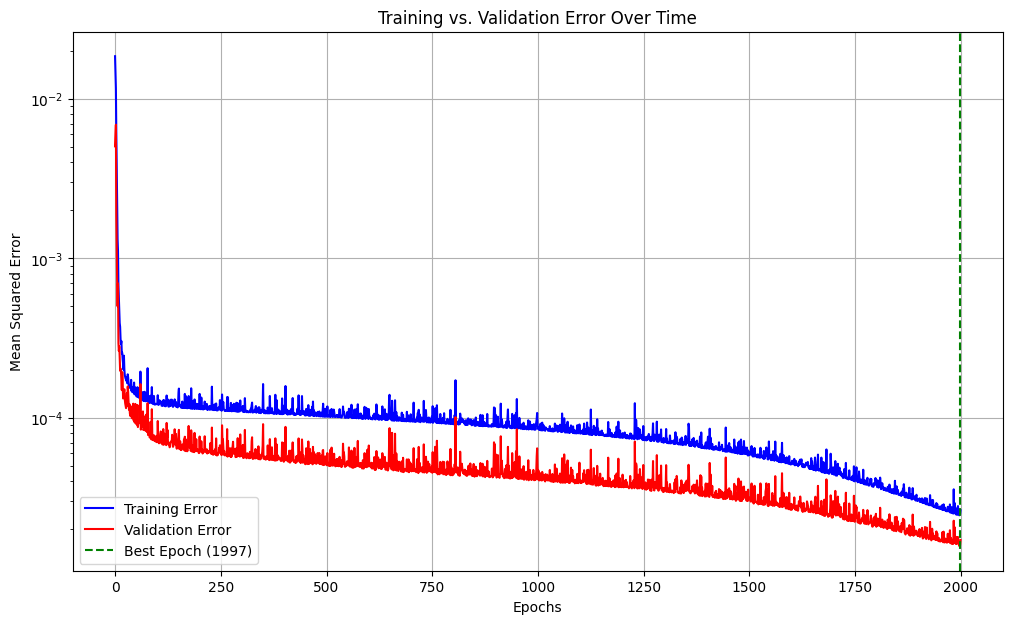

In [10]:
plt.figure(figsize=(12, 7))
plt.plot(train_errors, label='Training Error', color='blue')
plt.plot(validation_errors, label='Validation Error', color='red')
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training vs. Validation Error Over Time')
plt.legend()
plt.grid(True)
plt.yscale('log') # Use a log scale for better visibility if errors are small
plt.savefig('learning_curve.png')
plt.show()

## 8. Evaluating the Best Model on Test Data

Now we take the best model (saved during training) and evaluate its performance on the unseen test data. We'll define several common regression metrics for a thorough evaluation.

In [12]:
# Prepare test data
X_test = test_data.iloc[:, :input_size].to_numpy()
y_test = test_data.iloc[:, -1].to_numpy()

# Normalize test features using training statistics
X_test_norm = normalize(X_test, X_min, X_max)

# Make predictions with the best model
normalized_predictions = predict(X_test_norm, best_weights["W1"], best_weights["b1"], best_weights["W2"], best_weights["b2"])

# Denormalize predictions to original scale
denormalized_predictions = denormalize(normalized_predictions.flatten(), y_min, y_max)

print("Test predictions generated and denormalized.")

Test predictions generated and denormalized.


### Performance Metrics

In [13]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def calculate_ce(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (numerator / denominator) if denominator != 0 else float('nan')

def calculate_rsqr(y_true, y_pred):
    correlation_matrix = np.corrcoef(y_true, y_pred)
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2

rmse_value = calculate_rmse(y_test, denormalized_predictions)
ce_value = calculate_ce(y_test, denormalized_predictions)
rsqr_value = calculate_rsqr(y_test, denormalized_predictions)

print(f"--- Test Set Performance ---")
print(f"Coefficient of Efficiency (CE): {ce_value:.4f}")
print(f"R-Squared (R²):               {rsqr_value:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_value:.4f}\n")

print("--- Statistics ---")
print(f"Actuals    - Min: {np.min(y_test):.2f}, Mean: {np.mean(y_test):.2f}, Max: {np.max(y_test):.2f}")
print(f"Predictions - Min: {np.min(denormalized_predictions):.2f}, Mean: {np.mean(denormalized_predictions):.2f}, Max: {np.max(denormalized_predictions):.2f}")

--- Test Set Performance ---
Coefficient of Efficiency (CE): 0.9914
R-Squared (R²):               0.9920
Root Mean Squared Error (RMSE): 1.0381

--- Statistics ---
Actuals    - Min: 0.00, Mean: 5.04, Max: 74.40
Predictions - Min: -1.02, Mean: 5.21, Max: 77.92


### Visualizing Predictions vs. Actuals

Finally, we plot the model's predictions against the actual values from the test set to visually inspect its performance.

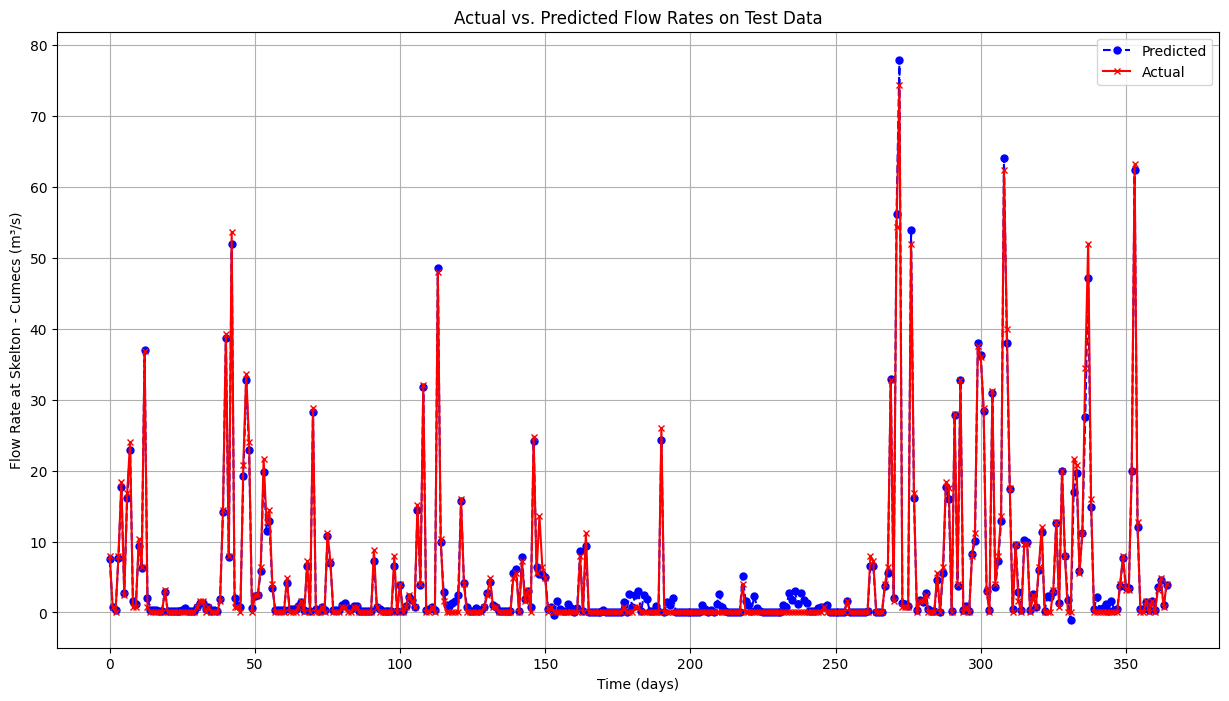

In [14]:
plt.figure(figsize=(15, 8))
plt.plot(denormalized_predictions, label='Predicted', color='blue', marker='o', linestyle='--', markersize=5)
plt.plot(y_test, label='Actual', color='red', marker='x', linestyle='-', markersize=5)
plt.xlabel('Time (days)')
plt.ylabel('Flow Rate at Skelton - Cumecs (m³/s)')
plt.title('Actual vs. Predicted Flow Rates on Test Data')
plt.legend()
plt.grid(True)
plt.show()